In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from util import load_events, plot_event, create_pairs, predict_pairs, create_triplets

In [2]:
events = load_events('toy_dataset.csv', chamber_id=None, start=0, end=1000)

Stations selected are:  [1 2 3 4 5 6]


In [3]:
help(create_pairs)

Help on function create_pairs in module util:

create_pairs(events)
    Create Hit Pairs
    Arguments :
    1. events (list ) : A list of events



In [4]:
# create training set (hit-pairs)
X, y = create_pairs(events)

  0%|          | 0/1000 [00:00<?, ?it/s]

Creating hit pairs ...


100%|██████████| 1000/1000 [00:19<00:00, 50.52it/s]


In [5]:
# random splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    random_state=1, 
                                                    shuffle=True, 
                                                    stratify=y)

In [6]:
# very simple keras model, build on that
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(100, activation='tanh', input_shape=(6,)),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(50, activation='tanh'),    
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               700       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 5,801
Trainable params: 5,801
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(X_train, y_train, epochs=15, batch_size=8192, validation_split=0.10)

Epoch 1/15
108/108 [==============================] - 5s 47ms/step - loss: 0.3768 - accuracy: 0.8213 - val_loss: 0.2652 - val_accuracy: 0.8604
Epoch 2/15
108/108 [==============================] - 5s 50ms/step - loss: 0.2235 - accuracy: 0.8923 - val_loss: 0.1772 - val_accuracy: 0.9472
Epoch 3/15
108/108 [==============================] - 5s 48ms/step - loss: 0.1645 - accuracy: 0.9368 - val_loss: 0.1413 - val_accuracy: 0.9488
Epoch 4/15
108/108 [==============================] - 5s 48ms/step - loss: 0.1385 - accuracy: 0.9487 - val_loss: 0.1241 - val_accuracy: 0.9527
Epoch 5/15
108/108 [==============================] - 5s 50ms/step - loss: 0.1248 - accuracy: 0.9538 - val_loss: 0.1143 - val_accuracy: 0.9573
Epoch 6/15
108/108 [==============================] - 5s 50ms/step - loss: 0.1166 - accuracy: 0.9570 - val_loss: 0.1079 - val_accuracy: 0.9594
Epoch 7/15
108/108 [==============================] - 5s 50ms/step - loss: 0.1108 - accuracy: 0.9590 - val_loss: 0.1029 - val_accuracy: 0.9613

In [8]:
# Evaluate the model on the test data using `evaluate`
print('Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=1024)

Evaluate on test data
107/107 [==============================] - 1s 6ms/step - loss: 0.0678 - accuracy: 0.9790


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 <a list of 6 Text major ticklabel objects>)

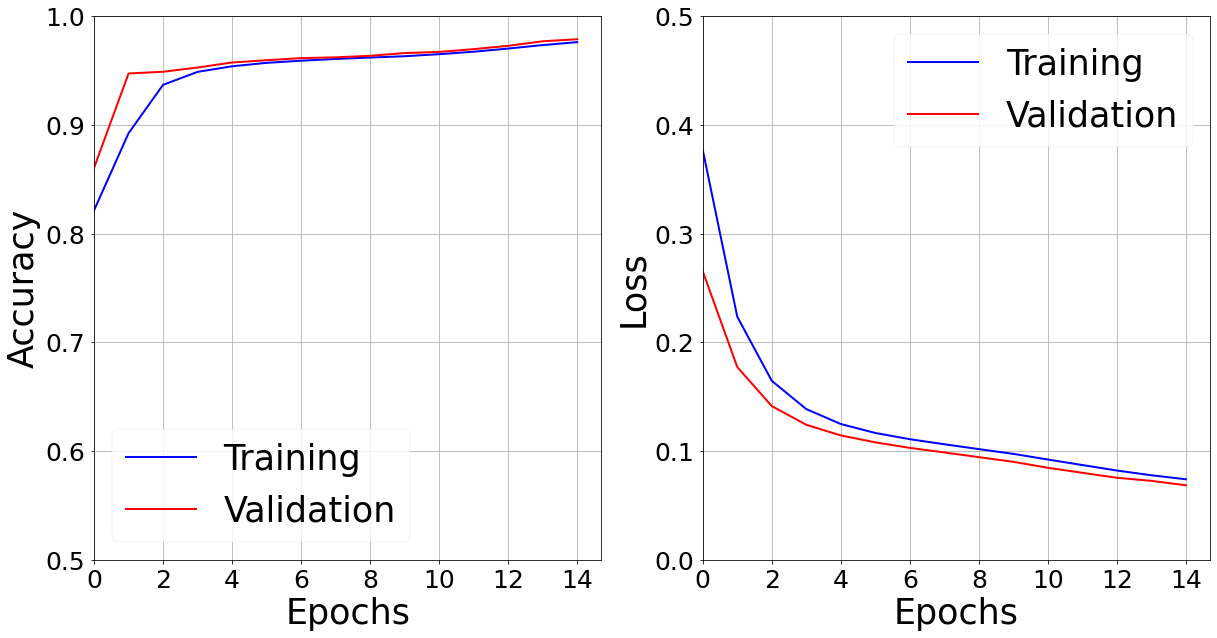

In [9]:
plt.style.use('seaborn-paper')
valid = history.history

fig = plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.plot(np.array(valid['accuracy']), label='Training',  color='blue', linewidth= 2)
plt.plot(np.array(valid['val_accuracy']), label='Validation',  color='red', linewidth= 2)
plt.xlim(0)
plt.ylim(0.5,1.00)
plt.grid(True)
plt.xlabel('Epochs', fontsize=35)
plt.ylabel('Accuracy', fontsize=35)
plt.legend(loc='best', fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.subplot(1, 2, 2)
plt.plot(np.array(valid['loss']), label='Training',  color='blue', linewidth= 2)
plt.plot(np.array(valid['val_loss']), label='Validation',  color='red', linewidth= 2)
plt.xlim(0)
plt.ylim(0.0,0.5)
plt.grid(True)
plt.xlabel('Epochs', fontsize=35)
plt.ylabel('Loss', fontsize=35)
plt.legend(loc='best', fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

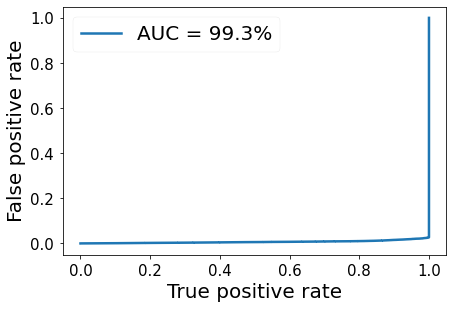

In [10]:
# plot ROC curve
y_pred = model.predict(X_test)
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test[:], y_pred[:])
    
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'True positive rate', fontsize=20)
plt.ylabel(r'False positive rate', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=20)
plt.tight_layout()

In [11]:
# lets predict on one event
help(predict_pairs)

Help on function predict_pairs in module util:

predict_pairs(data, model, cut=0.5)
    A function used to build hit-pairs and use the model to predict
    Arguments :
    1. data (dataframe) : An input event dataframe
    2. model (keras model) : A trained model for hit_pairs
    3. cut (float) : A threshold applied to the network output



In [12]:
df = events[0]
track_id = predict_pairs(df, model, 0.5)

In [13]:
# show track
reco_track = df[df['hit_id'].isin(track_id[1])]

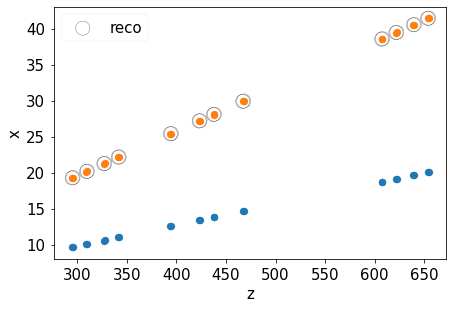

In [14]:
plot_event(df)
plt.scatter(reco_track.z, reco_track.x, s=200, facecolors='none', edgecolors='black', label='reco')
plt.legend(fontsize=15)

## Extend to triplet

In [15]:
# choose small number of events 
events = load_events('toy_dataset.csv', chamber_id='1,2', start=0, end=200)

Stations selected are:  [1 2]


In [16]:
# create training set (hit-triplets)
X, y = create_triplets(events)

  2%|▏         | 4/200 [00:00<00:05, 37.71it/s]

Creating hit pairs ...


100%|██████████| 200/200 [00:10<00:00, 19.65it/s]


In [17]:
# random splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    random_state=1, 
                                                    shuffle=True, 
                                                    stratify=y)

In [18]:
# very simple keras model, build on that
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(100, activation='tanh', input_shape=(9,)),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(50, activation='tanh'),    
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               1000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 6,101
Trainable params: 6,101
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, epochs=15, batch_size=4096, validation_split=0.10)

Epoch 1/15
182/182 [==============================] - 6s 32ms/step - loss: 0.1398 - accuracy: 0.9645 - val_loss: 0.1057 - val_accuracy: 0.9664
Epoch 2/15
182/182 [==============================] - 6s 34ms/step - loss: 0.0866 - accuracy: 0.9668 - val_loss: 0.0677 - val_accuracy: 0.9677
Epoch 3/15
182/182 [==============================] - 6s 32ms/step - loss: 0.0649 - accuracy: 0.9684 - val_loss: 0.0551 - val_accuracy: 0.9692
Epoch 4/15
182/182 [==============================] - 6s 32ms/step - loss: 0.0542 - accuracy: 0.9714 - val_loss: 0.0480 - val_accuracy: 0.9699
Epoch 5/15
182/182 [==============================] - 6s 33ms/step - loss: 0.0465 - accuracy: 0.9753 - val_loss: 0.0415 - val_accuracy: 0.9795
Epoch 6/15
182/182 [==============================] - 7s 39ms/step - loss: 0.0411 - accuracy: 0.9794 - val_loss: 0.0385 - val_accuracy: 0.9741
Epoch 7/15
182/182 [==============================] - 7s 37ms/step - loss: 0.0375 - accuracy: 0.9827 - val_loss: 0.0345 - val_accuracy: 0.9863

In [20]:
# Evaluate the model on the test data using `evaluate`
print('Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=1024)

Evaluate on test data
90/90 [==============================] - 1s 8ms/step - loss: 0.0278 - accuracy: 0.9873


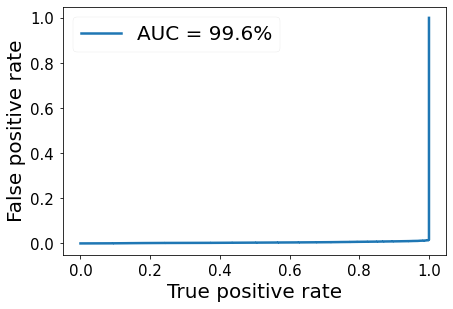

In [21]:
# plot ROC curve
y_pred = model.predict(X_test)
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test[:], y_pred[:])
    
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'True positive rate', fontsize=20)
plt.ylabel(r'False positive rate', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=20)
plt.tight_layout()